# Cell 1 - Data loading and feature extraction

Loading custom dataset:  50%|█████     | 10000/19918 [00:35<00:35, 281.67it/s]


Loaded 10000 records
normal_ecg : 5200 records
ST : 232 records
RBBB : 217 records
AF : 206 records
LBBB : 204 records
1dAVb : 149 records
SB : 127 records
Stored labels for additional dataset
made syntehtic anomalies
Loaded model and scalar
model: fastai_resnet1d_wang


C:\Users\nikolai\anaconda3\envs\NEWECGumapTest\lib\site-packages\fastai\basic_train.py:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(source, map_loca

Extracting features
Loaded DL features
Loaded TD features
Loaded DL features
Loaded TD features
Loaded DL features
Loaded TD features
Loaded DL features
Loaded TD features
Loaded DL features
Loaded TD features


Extracting features: 100%|██████████| 6/6 [00:00<00:00, 14.38it/s]


Loaded DL features
Loaded TD features
Saving features


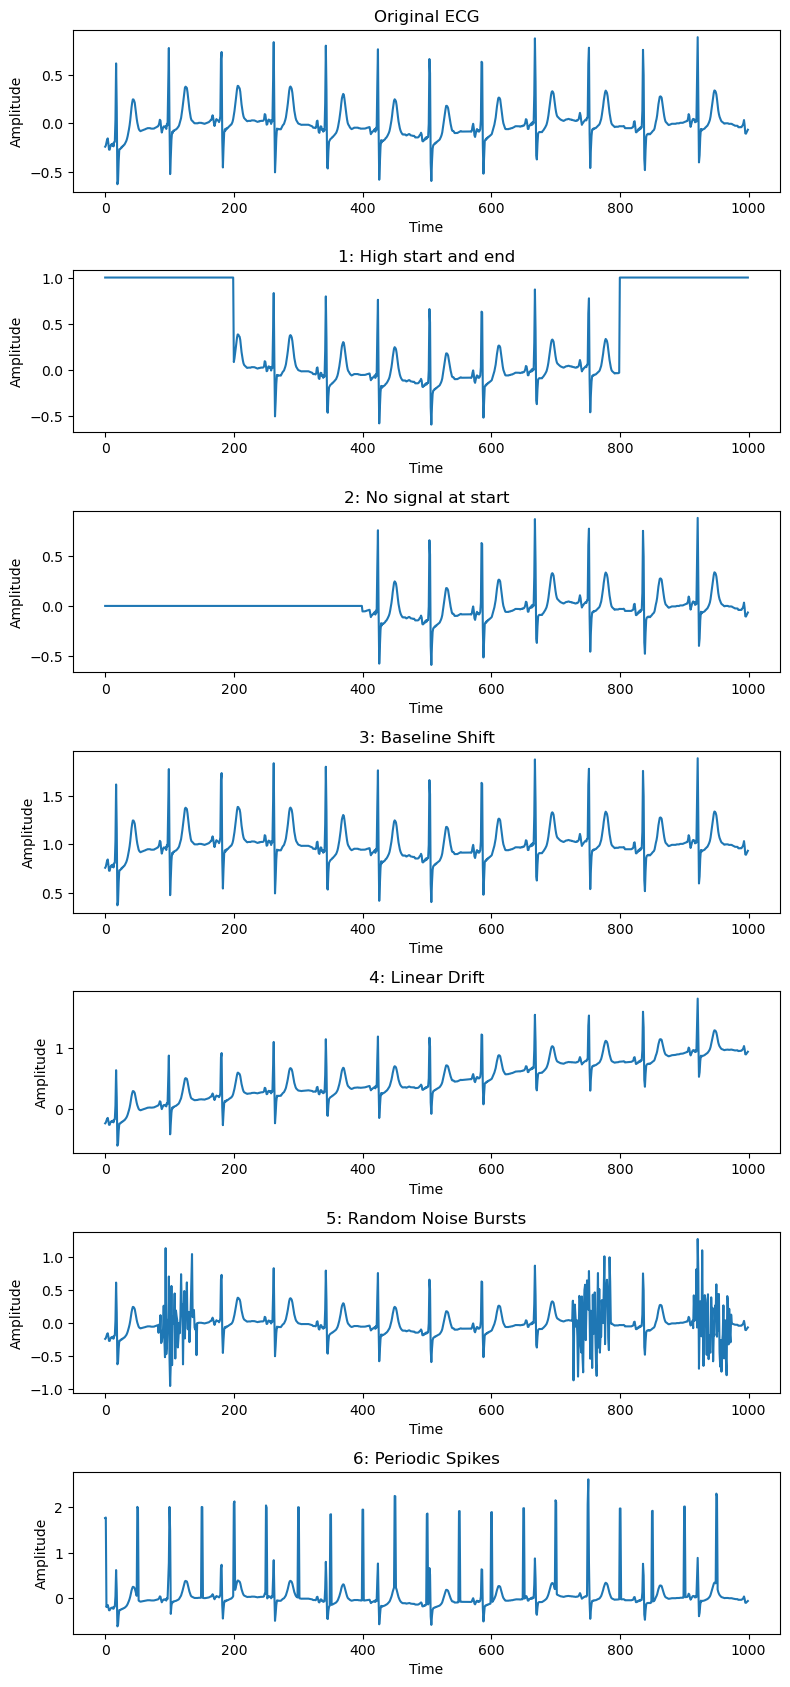

Done!


In [1]:
import os
import pickle
import numpy as np
import torch
from tqdm import tqdm
from sklearn.preprocessing import normalize
from utils import utils
from models.fastai_model import fastai_model
import pandas as pd
import glob
import wfdb
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from utility_functions.data_functions import *


# Variables for importing model and PTB-XL data
sampling_frequency = 100
datafolder = '../data/ptbxl/'
outputfolder = '../output/'
task = 'superdiagnosticNORMandMI'
anomaly_task = 'superdiagnosticNotNORMandMI'
modelname = 'fastai_resnet1d_wang' # change model here: fastai_xresnet1d101, fastai_inception1d
num_classes = 2
input_shape = [1000, 12]
experiment = 'exp1.1.1'
mpath = f'../output/{experiment}/models/{modelname}/'
pretrainedfolder = mpath
new_wfdb_folder = os.path.join("..", "data", "wfdb15")
new_csv_file = os.path.join("..", "data", "exams.csv")
target_length = 1000
max_records = 10000
# Used for consistent output
np.random.seed(42)
torch.manual_seed(42)
os.makedirs(outputfolder, exist_ok=True)





    

    
    
# loads the PTB-XL data using superdiagnosticNotNORMandMI, meaning STTC, CD and HYP classes
data_diff, raw_labels_diff = utils.load_dataset(datafolder, sampling_frequency)
labels_diff = utils.compute_label_aggregations(raw_labels_diff, datafolder, 'superdiagnosticNotNORMandMI')
data_diff, labels_diff, _, _ = utils.select_data(
    data_diff, labels_diff, 'superdiagnosticNotNORMandMI', min_samples=0, outputfolder=outputfolder
)

# Loads the superdiagnosticNORMandMI data, meaning Normal and MI classes
data, raw_labels = utils.load_dataset(datafolder, sampling_frequency)
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
data, labels, _, _ = utils.select_data(data, labels, task, min_samples=0, outputfolder=outputfolder)


# Splits data into diffrent sets using the pre-defined folds, 1-8 is training
# 9 is validation and 10 is testing
folds_1_8 = (labels.strat_fold <= 8)
data_norm_ref = data[folds_1_8]
folds9_norm = labels.strat_fold == 9
folds9_diff = labels_diff.strat_fold == 9
data_norm_val = data[folds9_norm]
data_notnorm_val = data_diff[folds9_diff]
folds10_norm = labels.strat_fold == 10
folds10_diff = labels_diff.strat_fold == 10
data_norm_test = data[folds10_norm]
data_notnorm_test = data_diff[folds10_diff]


# load the additional dataset, code15
new_data, new_record_ids, new_df = load_custom_data(new_wfdb_folder, new_csv_file, max_records)
# load metadata for additinal dataset
if len(new_data) > 0:
    with open(os.path.join(outputfolder, f'{experiment}_new_record_ids.pkl'), 'wb') as f:
        pickle.dump(new_record_ids, f)
    ecg_cols = ['normal_ecg', 'RBBB', 'AF', 'LBBB', '1dAVb', 'ST', 'SB']
    counts = []
    diagnostic_data = {}
    for col in ecg_cols:
        if col in new_df.columns:
            col_data = new_df[col].iloc[:len(new_data)].values
            diagnostic_data[col] = col_data
            count = np.sum(col_data)
            if count > 0:
                counts.append((col, count))


    for col, count in sorted(counts, key=lambda x: x[1], reverse=True):
        print(f"{col} : {count} records")

    with open(os.path.join(outputfolder, f'{experiment}_new_diagnostic_labels.pkl'), 'wb') as f:
        pickle.dump(diagnostic_data, f)
    print("Stored labels for additional dataset") 

    
# Create syntehtic anomalies 
test_indices_norm = np.where(folds10_norm)[0]
test_data_diff_fold10 = data[test_indices_norm]

rng = np.random.default_rng(seed=77) 
chosen_idx = rng.choice(len(test_data_diff_fold10), size=1, replace=False)[0]
base_synth_anom = test_data_diff_fold10[chosen_idx]
synthetic_anomalies = create_synthetic_anomalies(base_synth_anom)
print("made syntehtic anomalies")


    
# Load the standard scalar
scaler_path = f'../output/{experiment}/data/standard_scaler.pkl'
if not os.path.exists(scaler_path): raise FileNotFoundError(scaler_path)
with open(scaler_path, 'rb') as f: standard_scaler = pickle.load(f)
print("Loaded model and scalar")


# Load the trained ResNet model
model = fastai_model(
    modelname,
    num_classes,
    sampling_frequency,
    mpath,
    input_shape=input_shape,
    pretrainedfolder=pretrainedfolder,
    n_classes_pretrained=num_classes,
    pretrained=True,
    epochs_finetuning=0,
)

# some dummy data needed to load model but is not used otherwise
dummy_X = [np.zeros(input_shape, dtype=np.float32)]
dummy_y = [0]
learn = model._get_learner(dummy_X, dummy_y, dummy_X, dummy_y)
learn.load(model.name) 
pytorch_model = learn.model
pytorch_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_model.to(device)



# Define hook for extracting features
layer_features = {}
def hook_fn(module_name):
    def hook(module, inp, out): layer_features[module_name] = out.detach().cpu().numpy()
    return hook
hooks = []
hooks.append(pytorch_model[-1][-2].register_forward_hook(hook_fn("Batch_norm"))) 










### Extracting features ###
print("Extracting features")

# Extract normal and mi data from training set
feat_file_ref = os.path.join(outputfolder, f'{experiment}_features_fold_1_8_ref.pkl')
td_feat_file_ref = os.path.join(outputfolder, f'{experiment}_td_features_fold_1_8_ref.pkl')
feats_norm_ref, td_feats_norm_ref = load_or_extract(
    feat_file_ref, data_norm_ref, td_feat_file_ref,
    pytorch_model, standard_scaler, device, layer_features
)

# Normalize  features
feats_norm_ref_norm = normalize(feats_norm_ref, norm='l2')

td_feats_norm_ref_mean = np.mean(td_feats_norm_ref, axis=0)
td_feats_norm_ref_std = np.std(td_feats_norm_ref, axis=0)
td_feats_norm_ref_std[td_feats_norm_ref_std < 1e-6] = 1e-6 
td_feats_norm_ref_z = (td_feats_norm_ref - td_feats_norm_ref_mean) / td_feats_norm_ref_std

normalization_params = {'td_feats_norm_mean': td_feats_norm_ref_mean, 'td_feats_norm_std': td_feats_norm_ref_std}
with open(os.path.join(outputfolder, f'{experiment}_normalization_params.pkl'), 'wb') as f:
    pickle.dump(normalization_params, f)
    
    

# Extract normal and mi data from validation set
feat_file_norm_val = os.path.join(outputfolder, f'{experiment}_features_fold9_norm_val.pkl')
td_feat_file_norm_val = os.path.join(outputfolder, f'{experiment}_td_features_fold9_norm_val.pkl')
feats_norm_val, td_feats_norm_val = load_or_extract(feat_file_norm_val, data_norm_val, td_feat_file_norm_val, pytorch_model, standard_scaler, device, layer_features)
feats_norm_val_norm = normalize(feats_norm_val, norm='l2')
td_feats_norm_val_z = (td_feats_norm_val - td_feats_norm_ref_mean) / td_feats_norm_ref_std

# Extract other classes (STTC, CD,HYP) data from validation set
feat_file_notnorm_val = os.path.join(outputfolder, f'{experiment}_features_fold9_notnorm_val.pkl')
td_feat_file_notnorm_val = os.path.join(outputfolder, f'{experiment}_td_features_fold9_notnorm_val.pkl')
feats_notnorm_val, td_feats_notnorm_val = load_or_extract(feat_file_notnorm_val, data_notnorm_val, td_feat_file_notnorm_val, pytorch_model, standard_scaler, device, layer_features)
feats_notnorm_val_norm = normalize(feats_notnorm_val, norm='l2')
td_feats_notnorm_val_z = (td_feats_notnorm_val - td_feats_norm_ref_mean) / td_feats_norm_ref_std

# Extract normal and mi data from test set
feat_file_norm_test = os.path.join(outputfolder, f'{experiment}_features_fold10_norm_test.pkl')
td_feat_file_norm_test = os.path.join(outputfolder, f'{experiment}_td_features_fold10_norm_test.pkl')
feats_norm_test, td_feats_norm_test = load_or_extract(feat_file_norm_test, data_norm_test, td_feat_file_norm_test, pytorch_model, standard_scaler, device, layer_features)
feats_norm_test_norm = normalize(feats_norm_test, norm='l2')
td_feats_norm_test_z = (td_feats_norm_test - td_feats_norm_ref_mean) / td_feats_norm_ref_std

# Extract other classes (STTC, CD,HYP) data from test set
feat_file_notnorm_test = os.path.join(outputfolder, f'{experiment}_features_fold10_notnorm_test.pkl')
td_feat_file_notnorm_test = os.path.join(outputfolder, f'{experiment}_td_features_fold10_notnorm_test.pkl')
feats_notnorm_test, td_feats_notnorm_test = load_or_extract(feat_file_notnorm_test, data_notnorm_test, td_feat_file_notnorm_test, pytorch_model, standard_scaler, device, layer_features)
feats_notnorm_test_norm = normalize(feats_notnorm_test, norm='l2')
td_feats_notnorm_test_z = (td_feats_notnorm_test - td_feats_norm_ref_mean) / td_feats_norm_ref_std


# extracting features syntethic anomalies
if len(synthetic_anomalies) > 0:
    feat_file_synth = os.path.join(outputfolder, f'{experiment}_features_synth.pkl')
    td_feat_file_synth = os.path.join(outputfolder, f'{experiment}_td_features_synth.pkl')
    feats_synth, td_feats_synth = extract_features(synthetic_anomalies, pytorch_model, standard_scaler, device, layer_features)
    with open(feat_file_synth, 'wb') as f: pickle.dump(feats_synth, f)
    with open(td_feat_file_synth, 'wb') as f: pickle.dump(td_feats_synth, f)
    feats_synth_norm = normalize(feats_synth, norm='l2')
    td_feats_synth_z = (td_feats_synth - td_feats_norm_ref_mean) / td_feats_norm_ref_std
else:
    feats_synth_norm, td_feats_synth_z = np.array([]), np.array([])

    
# Extract additional dataset
if len(new_data) > 0:
    feat_file_new = os.path.join(outputfolder, f'{experiment}_features_new_dataset.pkl')
    td_feat_file_new = os.path.join(outputfolder, f'{experiment}_td_features_new_dataset.pkl')
    feats_new, td_feats_new = load_or_extract(feat_file_new, np.array(new_data), td_feat_file_new, pytorch_model, standard_scaler, device, layer_features)
    feats_new_norm = normalize(feats_new, norm='l2')
    td_feats_new_z = (td_feats_new - td_feats_norm_ref_mean) / td_feats_norm_ref_std
else:
    feats_new_norm, td_feats_new_z = np.array([]), np.array([])

    
    
# Save the extracted and normalized features
print("Saving features")
with open(os.path.join(outputfolder, f'{experiment}_feats_normal_ref_norm.pkl'), 'wb') as f: pickle.dump(feats_norm_ref_norm, f)
with open(os.path.join(outputfolder, f'{experiment}_td_feats_normal_ref_z.pkl'), 'wb') as f: pickle.dump(td_feats_norm_ref_z, f)
with open(os.path.join(outputfolder, f'{experiment}_feats_norm_val_norm.pkl'), 'wb') as f: pickle.dump(feats_norm_val_norm, f)
with open(os.path.join(outputfolder, f'{experiment}_td_feats_norm_val_z.pkl'), 'wb') as f: pickle.dump(td_feats_norm_val_z, f)
with open(os.path.join(outputfolder, f'{experiment}_feats_notnorm_val_norm.pkl'), 'wb') as f: pickle.dump(feats_notnorm_val_norm, f)
with open(os.path.join(outputfolder, f'{experiment}_td_feats_notnorm_val_z.pkl'), 'wb') as f: pickle.dump(td_feats_notnorm_val_z, f)
with open(os.path.join(outputfolder, f'{experiment}_feats_norm_test_norm.pkl'), 'wb') as f: pickle.dump(feats_norm_test_norm, f)
with open(os.path.join(outputfolder, f'{experiment}_td_feats_norm_test_z.pkl'), 'wb') as f: pickle.dump(td_feats_norm_test_z, f)
with open(os.path.join(outputfolder, f'{experiment}_feats_notnorm_test_norm.pkl'), 'wb') as f: pickle.dump(feats_notnorm_test_norm, f)
with open(os.path.join(outputfolder, f'{experiment}_td_feats_notnorm_test_z.pkl'), 'wb') as f: pickle.dump(td_feats_notnorm_test_z, f)

    
if len(feats_synth_norm) > 0:
    with open(os.path.join(outputfolder, f'{experiment}_feats_anomalies_synth_norm.pkl'), 'wb') as f: pickle.dump(feats_synth_norm, f)
    with open(os.path.join(outputfolder, f'{experiment}_td_feats_anomalies_synth_z.pkl'), 'wb') as f: pickle.dump(td_feats_synth_z, f)

        
if len(feats_new_norm) > 0:
    with open(os.path.join(outputfolder, f'{experiment}_feats_new_norm.pkl'), 'wb') as f: pickle.dump(feats_new_norm, f)
    with open(os.path.join(outputfolder, f'{experiment}_td_feats_new_z.pkl'), 'wb') as f: pickle.dump(td_feats_new_z, f)


for hook in hooks: hook.remove()

    
    
    

    
    
# count of plots, synethic anomalies + 1 normal 
num_synthetic = synthetic_anomalies.shape[0]
num_total_plots = 1 + num_synthetic

n_rows = num_total_plots
n_cols = 1


fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, n_rows * 2.5), squeeze=False) 
axes = axes.flatten() 

plot_idx = 0

# Plot the original ECG if it's available
if base_synth_anom is not None and base_synth_anom.size > 0:
    ax = axes[plot_idx]
    ax.plot(base_synth_anom[:, 6]) 
    ax.set_title("Original ECG")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    plot_idx += 1

anomaly_names = [
    "1: High start and end",
    "2: No signal at start",
    "3: Baseline Shift",
    "4: Linear Drift",
    "5: Random Noise Bursts",
    "6: Periodic Spikes"
]

# Plot synthetic anomalys
for i in range(num_synthetic):
    ax = axes[plot_idx]
    ax.plot(synthetic_anomalies[i, :, 6])
    title = anomaly_names[i] if i < len(anomaly_names) else f"Synthetic Anomaly {i+1}"
    ax.set_title(f"{title}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    plot_idx += 1


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show() 



    
    
    
    
    
    
    
    
    
    
    
    
    
print("Done!")

# Cell 2 - Anomaly detection

In [2]:
import os
import pickle
import numpy as np
import itertools 
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from utility_functions.data_functions import *
from utility_functions.deviation_detection_functions import *

t = 0.1 # Mahalanobis score 
ensemble_bins = np.linspace(0, 1, 11) # Bins for score histograms
outputfolder = '../output/'
experiment = 'exp1.1.1'
np.random.seed(42) # For reproducibility
method_names = ['maha', 'knn', 'iso', 'ocsvm', 'lof']



# Print the final distrobution of scores, including count of flaggs and a text histogram
def print_ensemble_distribution(name, scores, threshold):
    scores_clean = np.nan_to_num(scores, nan=-1.0)
    flagged = np.sum(scores_clean > threshold)
    total = len(scores_clean)
    pct = flagged / total * 100 if total > 0 else 0
    print(f"{name}: {flagged}/{total} flagged ({pct:.1f}%)")

    counts, edges = np.histogram(scores_clean, bins=ensemble_bins)

    print(f"- [0.0 - 0.1): {counts[0]}")
    print(f"- [0.1 - 0.2): {counts[1]}")
    print(f"- [0.2 - 0.3): {counts[2]}")
    print(f"- [0.3 - 0.4): {counts[3]}")
    remaining_sum = sum(counts[4:])
    if remaining_sum > 0:
        print(f"- [0.4 - 0.5): {counts[4]}")
        print(f"- [0.5 - 0.6): {counts[5]}")
        print(f"- [0.6 - 0.7): {counts[6]}")
        print(f"- [0.7 - 0.8): {counts[7]}")
        print(f"- [0.8 - 0.9): {counts[8]}")
        print(f"- [0.9 - 1.0]: {counts[9]}")
    else:
        print("- [0.4 - 1.0]: 0")


        

#Load the features
features = load_features() 



print("\nStarting anomaly detection")


# Mahalanobis distance
print("Mahalanobis distance...")
ref_dl_clean = np.nan_to_num(features.get('dl_normal_ref', np.array([])))
ref_td_clean = np.nan_to_num(features.get('td_normal_ref', np.array([])))

# calculating mean and covariance matrix needed for Mahalanobis distance
mu_dl = np.mean(ref_dl_clean, axis=0)
cov_dl = np.cov(ref_dl_clean, rowvar=False) + np.eye(ref_dl_clean.shape[1]) * 1e-6
cov_inv_dl = np.linalg.pinv(cov_dl)
mu_td = np.mean(ref_td_clean, axis=0)
cov_td = np.cov(ref_td_clean, rowvar=False) + np.eye(ref_td_clean.shape[1]) * 1e-6
cov_inv_td = np.linalg.pinv(cov_td)

dists = {}
all_feature_keys = [k for k in features.keys() if k.startswith('dl_') or k.startswith('td_')]
for ds_key in all_feature_keys:
    feat_type = 'dl' if ds_key.startswith('dl_') else 'td'
    base_key = ds_key.replace(f'{feat_type}_', '', 1)
    mu, cov_inv = (mu_dl, cov_inv_dl) if feat_type == 'dl' else (mu_td, cov_inv_td)

    if features[ds_key].size > 0:
        dists[f'd_{base_key}_{feat_type}'] = compute_mahalanobis_distance(features[ds_key], mu, cov_inv)
    else:
        dists[f'd_{base_key}_{feat_type}'] = np.array([])

ref_dist_dl = dists.get('d_normal_ref_dl', np.array([]))
ref_dist_td = dists.get('d_normal_ref_td', np.array([]))
scaling_dl = np.median(ref_dist_dl[np.isfinite(ref_dist_dl)])
scaling_td = np.median(ref_dist_td[np.isfinite(ref_dist_td)])


scores_maha_dl = {key[2:-3]: compute_mahalanobis_scores(dist, scaling_dl) for key, dist in dists.items() if key.endswith('_dl')}
scores_maha_td = {key[2:-3]: compute_mahalanobis_scores(dist, scaling_td) for key, dist in dists.items() if key.endswith('_td')}



# kNN
print("kNN...")
knn_dl = fit_knn(features['dl_normal_ref'])
knn_td = fit_knn(features['td_normal_ref'])
scores_knn_dl = {key.replace('dl_', '', 1): compute_knn_outlier_scores(knn_dl, feat) for key, feat in features.items() if key.startswith('dl_')}
scores_knn_td = {key.replace('td_', '', 1): compute_knn_outlier_scores(knn_td, feat) for key, feat in features.items() if key.startswith('td_')}



# Isolation forest
print("Isolation forest...")
iso_forest_dl = fit_isolation_forest(features['dl_normal_ref'])
iso_forest_td = fit_isolation_forest(features['td_normal_ref'])
scores_iso_dl = {key.replace('dl_', '', 1): compute_isolation_forest_scores(iso_forest_dl, feat) for key, feat in features.items() if key.startswith('dl_')}
scores_iso_td = {key.replace('td_', '', 1): compute_isolation_forest_scores(iso_forest_td, feat) for key, feat in features.items() if key.startswith('td_')}



# One Class SVM
print("One Class SVM...")
ocsvm_dl = fit_one_class_svm(features['dl_normal_ref'])
ocsvm_td = fit_one_class_svm(features['td_normal_ref'])
scores_ocsvm_dl = {key.replace('dl_', '', 1): compute_ocsvm_scores(ocsvm_dl, feat) for key, feat in features.items() if key.startswith('dl_')}
scores_ocsvm_td = {key.replace('td_', '', 1): compute_ocsvm_scores(ocsvm_td, feat) for key, feat in features.items() if key.startswith('td_')}



#Local outlier factor
print("Local outlier factor...")
lof_dl = fit_lof(features['dl_normal_ref'])
lof_td = fit_lof(features['td_normal_ref'])
scores_lof_dl = {key.replace('dl_', '', 1): compute_lof_scores(lof_dl, feat) for key, feat in features.items() if key.startswith('dl_')}
scores_lof_td = {key.replace('td_', '', 1): compute_lof_scores(lof_td, feat) for key, feat in features.items() if key.startswith('td_')}


# disct with all scores for each methode
all_scores_dl = {'maha': scores_maha_dl, 'knn': scores_knn_dl, 'iso': scores_iso_dl, 'ocsvm': scores_ocsvm_dl, 'lof': scores_lof_dl}
all_scores_td = {'maha': scores_maha_td, 'knn': scores_knn_td, 'iso': scores_iso_td, 'ocsvm': scores_ocsvm_td, 'lof': scores_lof_td}


# Create dicts for scaled features with methode names (maha,knn,iso,ocsvm,lof)
scaled_scores_dl = {method: {} for method in method_names}
scaled_scores_td = {method: {} for method in method_names}

# scale scores
for method, scores_dict in all_scores_dl.items():
    ref_scores = scores_dict.get('normal_ref', np.array([]))
    for dataset, scores in scores_dict.items():
        scaled_scores_dl[method][dataset] = min_max_scale(scores, ref_scores)
        
for method, scores_dict in all_scores_td.items():
    ref_scores = scores_dict.get('normal_ref', np.array([]))
    for dataset, scores in scores_dict.items():
        scaled_scores_td[method][dataset] = min_max_scale(scores, ref_scores)

        
        

print("\nOptimizing weights on validation set")

# Prepare scores
val_normal_scores_dl = {m: scaled_scores_dl[m].get('norm_val', np.array([])) for m in method_names}
val_anomaly_scores_dl = {m: scaled_scores_dl[m].get('notnorm_val', np.array([])) for m in method_names}
val_normal_scores_td = {m: scaled_scores_td[m].get('norm_val', np.array([])) for m in method_names}
val_anomaly_scores_td = {m: scaled_scores_td[m].get('notnorm_val', np.array([])) for m in method_names}



# DL features
dl_search_results = random_search_cv(val_normal_scores_dl, val_anomaly_scores_dl, len(method_names))
best_weights_dl = print_random_search_results(dl_search_results, "Deep Learning")
dl_cv_auc = dl_search_results['best_metrics']['roc_auc']



# TD features

td_search_results = random_search_cv(val_normal_scores_td, val_anomaly_scores_td, len(method_names))
best_weights_td = print_random_search_results(td_search_results, "Time Domain")
td_cv_auc = td_search_results['best_metrics']['roc_auc']




# best weights after 100 000 rounds
#maha: 0.010
#knn: 0.000
#iso: 0.084
#ocsvm: 0.010
#lof: 0.896

#best_weights_dl = np.array([0.010, 0, 0.084, 0.010, 0.896])
#best_weights_td = np.array([0, 1, 0, 0, 0]) 

# for testing one methode
#best_weights_dl = np.array([0, 0, 0, 0, 1])
#best_weights_td = np.array([0, 1, 0, 0, 0])    









print("\nFinal ensamble")
print(f"Optimal DL features: {best_weights_dl}")
print(f"Optimal TD features: {best_weights_td}")



total_auc = dl_cv_auc + td_cv_auc

dl_weight = dl_cv_auc / total_auc # set to 1 to test only dl, other to 0
td_weight = td_cv_auc / total_auc # set to 1 to test only td, other to 0
print(f"Final feature weights = DL:{dl_weight:.3f}, TD:{td_weight:.3f}")






ensemble_scores = {}
all_dataset_keys = set(key.replace('dl_', '', 1) for key in features if key.startswith('dl_'))
all_dataset_keys.update(key.replace('td_', '', 1) for key in features if key.startswith('td_'))





for ds_key in all_dataset_keys:
    scores_dict_dl = {m: scaled_scores_dl.get(m, {}).get(ds_key, np.array([])) for m in method_names}
    ensemble_dl = compute_weighted_ensemble(scores_dict_dl, best_weights_dl) 

    scores_dict_td = {m: scaled_scores_td.get(m, {}).get(ds_key, np.array([])) for m in method_names}
    ensemble_td = compute_weighted_ensemble(scores_dict_td, best_weights_td) 

    if ensemble_dl.size > 0 and ensemble_td.size > 0:
        if len(ensemble_dl) == len(ensemble_td):
            ensemble_scores[ds_key] = dl_weight * ensemble_dl + td_weight * ensemble_td
        else:
            raise ValueError(f"Length TD and DL features error!")
    elif ensemble_dl.size > 0: ensemble_scores[ds_key] = ensemble_dl
    elif ensemble_td.size > 0: ensemble_scores[ds_key] = ensemble_td
    else: ensemble_scores[ds_key] = np.array([])


        

ensemble_threshold = find_optimal_threshold(
    ensemble_scores.get('norm_val', np.array([])),
    ensemble_scores.get('notnorm_val', np.array([]))
)
print(f"Final ensamble threshold: {ensemble_threshold:.4f}")



# Print ensamble dist for diffrent the different subsets
print("Refference / training set:")
print_ensemble_distribution("Reference Normals (Folds 1-8)", ensemble_scores.get('normal_ref', np.array([])), ensemble_threshold)

print("\nValidation set:")
print_ensemble_distribution("Validation Norm/MI (Fold 9)", ensemble_scores.get('norm_val', np.array([])), ensemble_threshold)
print_ensemble_distribution("Validation Not Norm/MI (Fold 9)", ensemble_scores.get('notnorm_val', np.array([])), ensemble_threshold)

print("\nTest set:")
print_ensemble_distribution("Test Norm/MI (Fold 10)", ensemble_scores.get('norm_test', np.array([])), ensemble_threshold)
print_ensemble_distribution("Test Not Norm/MI (Fold 10 - Anomalies)", ensemble_scores.get('notnorm_test', np.array([])), ensemble_threshold)

print("\nSyntethic set:")
print_ensemble_distribution("Synthetic anomalies", ensemble_scores.get('anomalies_synth', np.array([])), ensemble_threshold)



# aditional data set evaluation
if 'new' in ensemble_scores and ensemble_scores['new'].size > 0:
    print("\nNew/aditional data set:")
    new_scores = ensemble_scores['new']
    num_new_records = len(new_scores)

    flagged_indices = np.where(new_scores > ensemble_threshold)[0]
    normal_indices = np.where(new_scores <= ensemble_threshold)[0]
    flagged_pct = len(flagged_indices) / num_new_records * 100
    normal_pct = len(normal_indices) / num_new_records * 100
    print(f"Total ECGs: {num_new_records}")
    print(f"Flagged as anomalies: {len(flagged_indices)} ({flagged_pct:.1f}%)")
    print(f"Classified as normal: {len(normal_indices)} ({normal_pct:.1f}%)")

    print("\nNew Dataset")
    print_ensemble_distribution("New dataset", new_scores, ensemble_threshold)


    print("\nLabel analysis:")
    diagnostic_data = features['diagnostic_data']
    available_labels = list(diagnostic_data.keys())

    total_label_counts = {label: np.sum(data_vec[:num_new_records])
                          for label, data_vec in diagnostic_data.items() if len(data_vec) >= num_new_records}
    sorted_total_counts = sorted(total_label_counts.items(), key=lambda item: item[1], reverse=True)

    flagged_labels_summary = {label: 0 for label in available_labels}
    for idx in flagged_indices:
        if idx < num_new_records:
            for label in available_labels:
                 if label in diagnostic_data and idx < len(diagnostic_data[label]) and diagnostic_data[label][idx]:
                    flagged_labels_summary[label] += 1

    print("\nFlagging Rate per Label:")
    for label, total_with_label in sorted_total_counts:
        count_flagged_with_label = flagged_labels_summary.get(label, 0)

        percentage = (count_flagged_with_label / total_with_label) * 100
        print(f"{label}: Flagged {count_flagged_with_label}/{int(total_with_label)} ({percentage:.1f}%)")





print("\nInvidicual methods performance on test set")
print("Comparing training classes MI and NORM to unseen classes(STTC, HYP, CD)")

test_norm_dl = {m: scaled_scores_dl.get(m, {}).get('norm_test', np.array([])) for m in method_names}
test_notnorm_dl = {m: scaled_scores_dl.get(m, {}).get('notnorm_test', np.array([])) for m in method_names}
test_norm_td = {m: scaled_scores_td.get(m, {}).get('norm_test', np.array([])) for m in method_names}
test_notnorm_td = {m: scaled_scores_td.get(m, {}).get('notnorm_test', np.array([])) for m in method_names}

n_test_norm = len(ensemble_scores.get('norm_test', []))
n_test_notnorm = len(ensemble_scores.get('notnorm_test', []))


y_true_test = np.concatenate([np.zeros(n_test_norm), np.ones(n_test_notnorm)])

print("\nTD features:")
for method in method_names:
    norm_s = test_norm_td.get(method, np.array([]))
    notnorm_s = test_notnorm_td.get(method, np.array([]))
    y_score = np.concatenate([norm_s, notnorm_s])
    auc_val = calculate_metrics(y_true_test, y_score)['roc_auc']
    print(f"- Individual Test AUC for {method.upper()} with TD Features: {auc_val:.4f}")


print("\nDL features:")
for method in method_names:
    norm_s = test_norm_dl.get(method, np.array([]))
    notnorm_s = test_notnorm_dl.get(method, np.array([]))
    y_score = np.concatenate([norm_s, notnorm_s])
    auc_val = calculate_metrics(y_true_test, y_score)['roc_auc']
    print(f"Individual Test AUC for {method.upper()} with DL Features: {auc_val:.4f}")


print("\nFinal Ensamble score:")
# AUC
ens_norm = ensemble_scores.get('norm_test', np.array([]))
ens_notnorm = ensemble_scores.get('notnorm_test', np.array([]))
y_score_ensemble = np.concatenate([ens_norm, ens_notnorm])
auc_ensemble = calculate_metrics(y_true_test, y_score_ensemble)['roc_auc']
# F1
y_pred_binary_ensemble = (y_score_ensemble > ensemble_threshold).astype(int)
f1_ensemble = f1_score(y_true_test, y_pred_binary_ensemble)
print(f"Final ensamble AUC: {auc_ensemble:.4f}, F1: {f1_ensemble:.4f}")





print("\nDone!")

Loading features
Training data / refference set: 9286
Validation set: 1147 Norm/MI, 651 Not Norm/MI
Test Set 1168 Norm/MI, 645 Not Norm/MI
Syntethic anomalies: 6
New/additional data set: 10000

Starting anomaly detection
Mahalanobis distance...
kNN...
Isolation forest...
One Class SVM...
Local outlier factor...

Optimizing weights on validation set
Testing 100000 random weights with cross validation

BestDeep Learning weights:
Best CV auc: 0.7695
Final methode weights
maha: 0.010
knn: 0.000
iso: 0.084
ocsvm: 0.010
lof: 0.896
Testing 100000 random weights with cross validation

BestTime Domain weights:
Best CV auc: 0.7419
Final methode weights
maha: 0.000
knn: 1.000
iso: 0.000
ocsvm: 0.000
lof: 0.000

Final ensamble
Optimal DL features: [1.033323e-02 9.183663e-05 8.383447e-02 9.766669e-03 8.959738e-01]
Optimal TD features: [0. 1. 0. 0. 0.]
Final feature weights = DL:0.509, TD:0.491
Final ensamble threshold: 0.0641
Refference / training set:
Reference Normals (Folds 1-8): 2423/9286 flagg

# Cell 3 - Performance and Result Vizualization

Making plot for individual performance
Making plot for optimized weights
Making plot for ensamble score
Making plot for new dataset flagging rate
Make plot for ROC curve
Make plot for the flagging rate over diffrent datasets using the threshold


C:\Users\nikolai\AppData\Local\Temp\ipykernel_733320\3451738152.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=sorted_rates, y=sorted_labels, ax=ax4, palette="Blues", orient='h')


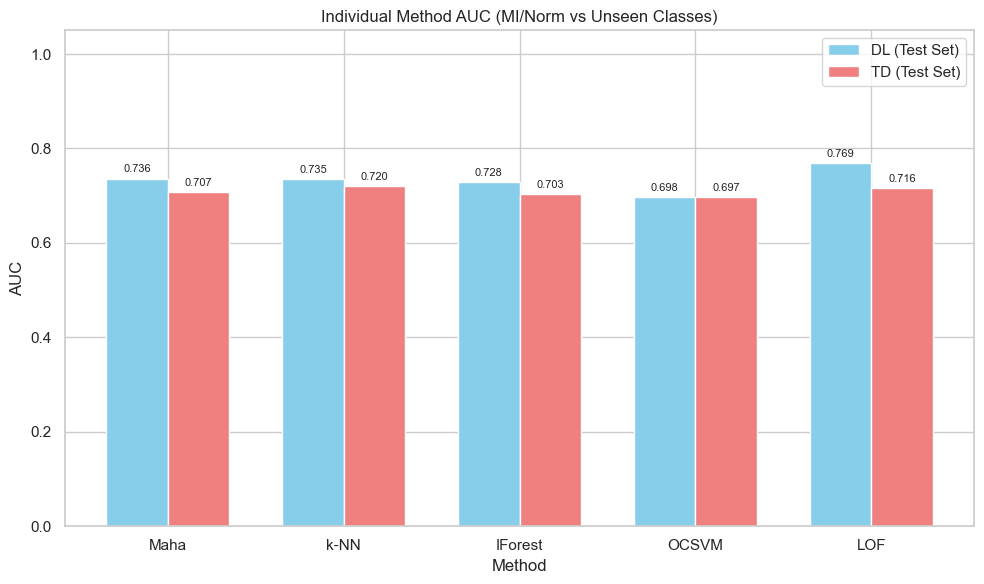

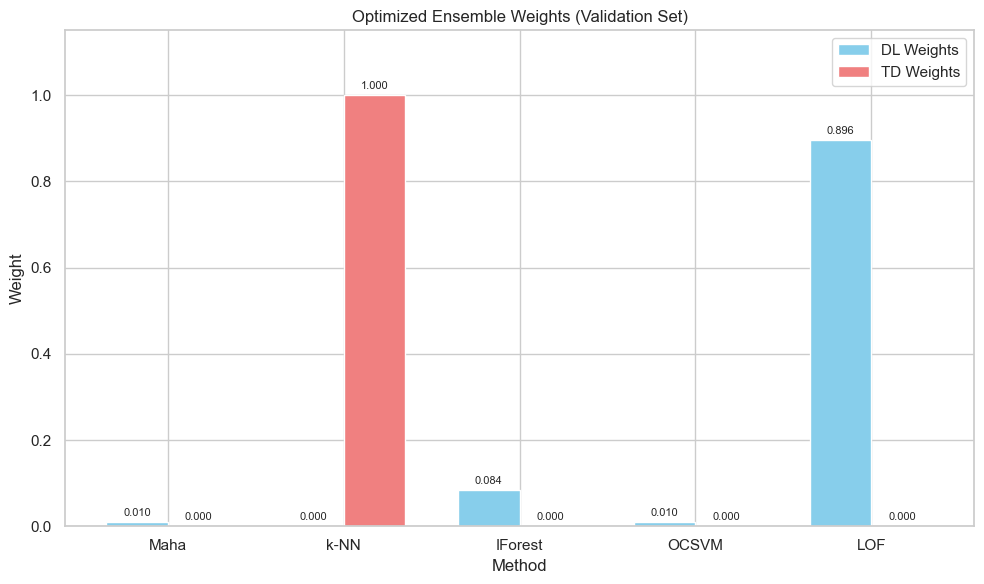

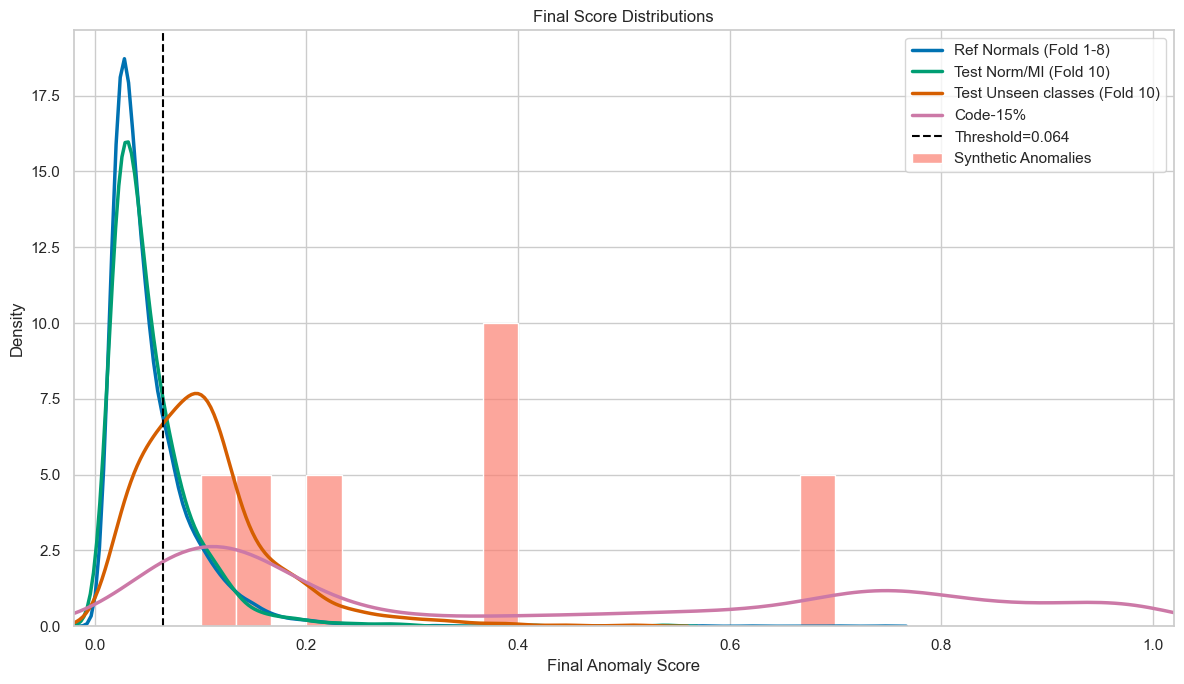

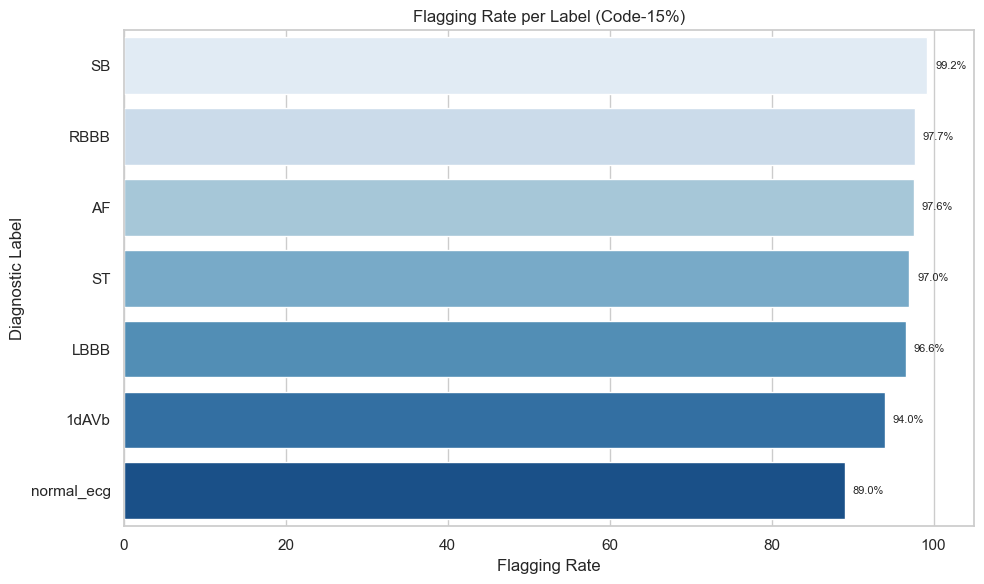

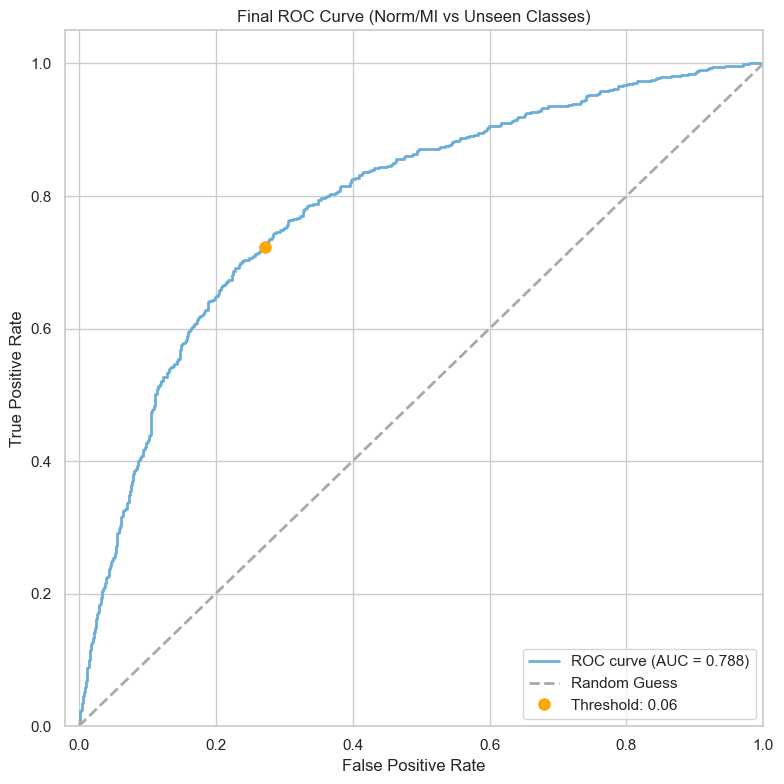

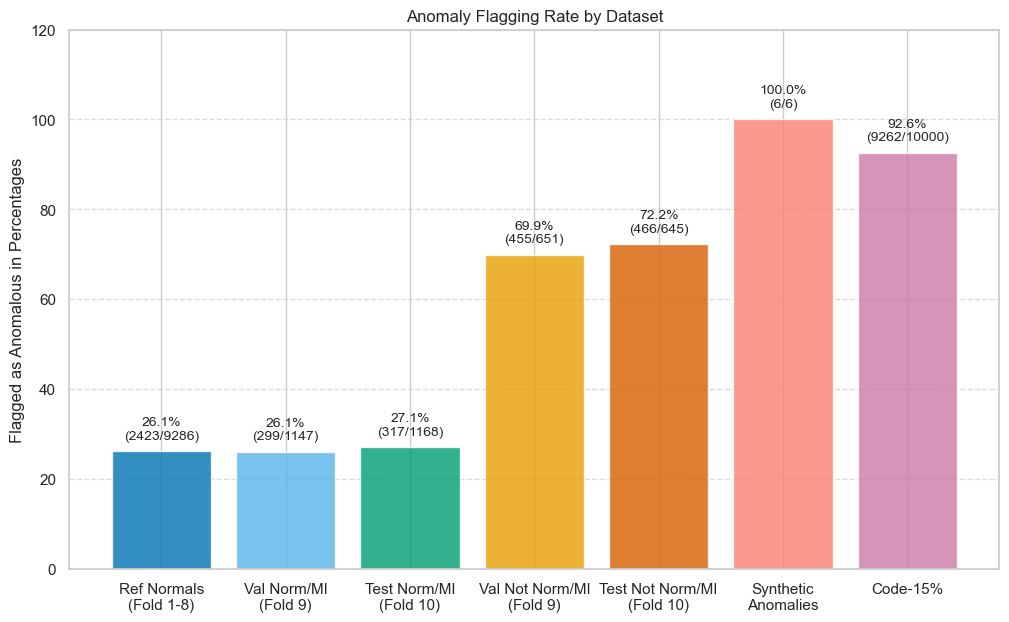

Done!


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
import os



# Global variables for style
plt.rcParams.update({
    'axes.titlesize': 14,       
    'axes.labelsize': 20,     
    'xtick.labelsize': 20,      
    'ytick.labelsize': 20,       
    'legend.fontsize': 20      
})



# Labels and seaborn defult styles
method_labels = ['Maha', 'k-NN', 'IForest', 'OCSVM', 'LOF'] 
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
width = 0.35 
x = np.arange(len(method_labels))



# Generating plot for individual performance

print("Making plot for individual performance")
auc_dl_values = []
auc_td_values = []
test_norm_key = 'norm_test'
test_notnorm_key = 'notnorm_test'

# Get lenghts for scores in seen(MI, NORM) and unseen(HYP, CD, STTC) classes
len_norm = len(scaled_scores_dl['knn'][test_norm_key])
len_notnorm = len(scaled_scores_dl['knn'][test_notnorm_key])
y_true_test = np.concatenate([np.zeros(len_norm), np.ones(len_notnorm)])

# Calculate the AUC score
for method in method_names:
    # Deep learning
    scores_norm_dl = scaled_scores_dl[method][test_norm_key]
    scores_notnorm_dl = scaled_scores_dl[method][test_notnorm_key]
    y_score_dl = np.concatenate([scores_norm_dl, scores_notnorm_dl])
    auc_dl = calculate_metrics(y_true_test, y_score_dl)['roc_auc']
    auc_dl_values.append(auc_dl)

    # Time-domain
    scores_norm_td = scaled_scores_td[method][test_norm_key]
    scores_notnorm_td = scaled_scores_td[method][test_notnorm_key]
    y_score_td = np.concatenate([scores_norm_td, scores_notnorm_td])
    auc_td = calculate_metrics(y_true_test, y_score_td)['roc_auc']
    auc_td_values.append(auc_td)

    
    
# plot 1, creates the bars for the individual method AUCs
fig1, ax1 = plt.subplots()
rects1 = ax1.bar(x - width/2, np.nan_to_num(auc_dl_values), width, label='DL (Test Set)', color='skyblue')
rects2 = ax1.bar(x + width/2, np.nan_to_num(auc_td_values), width, label='TD (Test Set)', color='lightcoral') 
ax1.set_ylabel('AUC')
ax1.set_xlabel('Method')
ax1.set_title('Individual Method AUC (MI/Norm vs Unseen Classes)')
ax1.set_xticks(x)
ax1.set_xticklabels(method_labels)
ax1.set_ylim(0, 1.05)
ax1.legend()

# Annotate the bars
for rect in rects1: 
    height = rect.get_height()
    ax1.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for rect in rects2: 
    height = rect.get_height()
    ax1.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
fig1.tight_layout()


# plot 2, plot optimized weights for each methode in the ensemble
print("Making plot for optimized weights")
fig2, ax2 = plt.subplots()
rects3 = ax2.bar(x - width/2,  best_weights_dl, width, label='DL Weights', color='skyblue')
rects4 = ax2.bar(x + width/2,  best_weights_td, width, label='TD Weights', color='lightcoral')
ax2.set_ylabel('Weight')
ax2.set_xlabel('Method')
ax2.set_title('Optimized Ensemble Weights (Validation Set)')
ax2.set_xticks(x)
ax2.set_xticklabels(method_labels)
max_w = max(np.max(best_weights_dl), np.max(best_weights_td))
ax2.set_ylim(0, max_w * 1.15 if max_w > 0 else 0.1)
ax2.legend()

# Annotate the bars
for rect in rects3: 
    height = rect.get_height()
    ax2.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points",ha='center', va='bottom', fontsize=8)
for rect in rects4: 
    height = rect.get_height()
    ax2.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points",ha='center', va='bottom', fontsize=8)
fig2.tight_layout()



# plot 3, plot of ensamble score distrobution
print("Making plot for ensamble score")
fig3, ax3 = plt.subplots(figsize=(12, 7))

plot_data_keys = {
    'Ref Normals (Fold 1-8)': 'normal_ref',
    'Test Norm/MI (Fold 10)': 'norm_test',
    'Test Unseen classes (Fold 10)': 'notnorm_test',
    'Synthetic Anomalies': 'anomalies_synth',
    'Code-15%': 'new'
}

# Colors for lines and bars
line_colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442']
synthetic_hist_color = '#FB8072'
num_bins_hist = 30
ensemble_bins_hist = np.linspace(0, 1, num_bins_hist + 1)
color_idx = 0


for plot_label, data_key in plot_data_keys.items():
    scores = ensemble_scores[data_key] 
    
    # Plot either bars for syntethic or lines for other data sets.
    if 'Synthetic' in plot_label:
        sns.histplot(scores, bins=ensemble_bins_hist, ax=ax3, kde=False, label=plot_label, stat="density", color=synthetic_hist_color, alpha=0.7, element="bars", fill=True)
    else:
        current_color = line_colors[color_idx % len(line_colors)]
        sns.kdeplot(scores, ax=ax3, label=plot_label, color=current_color, lw=2.5, warn_singular=False)
        color_idx += 1

        
ax3.axvline(ensemble_threshold, color='black', linestyle='--', lw=1.5, label=f'Threshold={ensemble_threshold:.3f}')
ax3.legend(loc='upper right')
ax3.set_xlabel('Final Anomaly Score')
ax3.set_ylabel('Density')
ax3.set_title('Final Score Distributions')
ax3.set_xlim(-0.02, 1.02)
ax3.set_ylim(bottom=0)
fig3.tight_layout()




# plot 4, plot for new/additional dataset, code-15 flagging rate, based on their labels
print("Making plot for new dataset flagging rate")
diagnostic_data = features['diagnostic_data']
ensemble_new_scores = ensemble_scores['new']

# FLagging rate for each label
flagging_rates = {}
flagged_indices_new = np.where(ensemble_new_scores > ensemble_threshold)[0]
num_new_records = len(ensemble_new_scores)
for label, values in diagnostic_data.items():
    values_subset = values[:num_new_records]
    total_with_label = np.sum(values_subset)

    if total_with_label > 0: 
        valid_flagged_indices = flagged_indices_new[flagged_indices_new < num_new_records]
        flagged_with_label = np.sum(values_subset[valid_flagged_indices])
        flagging_rates[label] = (flagged_with_label / total_with_label) * 100

# Plots the bars for each label        
sorted_labels = sorted(flagging_rates, key=flagging_rates.get, reverse=True)
sorted_rates = [flagging_rates[lbl] for lbl in sorted_labels]
fig4, ax4 = plt.subplots(figsize=(10, max(6, len(sorted_labels) * 0.5)))
bars = sns.barplot(x=sorted_rates, y=sorted_labels, ax=ax4, palette="Blues", orient='h')
ax4.set_xlabel('Flagging Rate')
ax4.set_ylabel('Diagnostic Label')
ax4.set_title(f'Flagging Rate per Label (Code-15%)')
ax4.set_xlim(0, 105)
for i, bar_value in enumerate(sorted_rates): ax4.text(bar_value + 1, i, f'{bar_value:.1f}%', va='center', ha='left', fontsize=8)
fig4.tight_layout()




# Plot 5, plot the ROC curve, which plots true postivies rate and false positive rate
# The used threshold is also shown as a dot
print("Make plot for ROC curve")
scores_norm_roc = ensemble_scores['norm_test']
scores_anomaly_roc = ensemble_scores['notnorm_test']

# ROC calculations
y_true_roc = np.concatenate([np.zeros_like(scores_norm_roc), np.ones_like(scores_anomaly_roc)])
y_score_roc = np.concatenate([scores_norm_roc, scores_anomaly_roc])
y_score_roc_clean = np.nan_to_num(y_score_roc, nan=0.0) 
fpr, tpr, thresholds_roc = roc_curve(y_true_roc, y_score_roc_clean)
roc_auc = auc(fpr, tpr)

# Plots curve
fig5, ax5 = plt.subplots(figsize=(8, 8))
ax5.plot(fpr, tpr, color='#6baed6', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax5.plot([0, 1], [0, 1], color='darkgray', lw=2, linestyle='--', label='Random Guess')

# Plot point for the threshold
operational_threshold_idx = np.argmin(np.abs(thresholds_roc - ensemble_threshold))
ax5.plot(fpr[operational_threshold_idx], tpr[operational_threshold_idx], color='orange', marker='o', linestyle='None', markersize=8, label=f'Threshold: {ensemble_threshold:.2f}')
# Shows labels
ax5.set_xlim([-0.02, 1.0])
ax5.set_ylim([0.0, 1.05])
ax5.set_xlabel('False Positive Rate')
ax5.set_ylabel('True Positive Rate')
ax5.set_title('Final ROC Curve (Norm/MI vs Unseen Classes)')
ax5.legend(loc="lower right")
ax5.grid(True)
fig5.tight_layout()



# Plot 6
print("Make plot for the flagging rate over diffrent datasets using the threshold")
fig6, ax6 = plt.subplots(figsize=(12, 7))

line_colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442']
synthetic_hist_color = '#FB8072'

datasets = [
    ('Ref Normals\n(Fold 1-8)', 'normal_ref', line_colors[0]),       
    ('Test Norm/MI\n(Fold 10)', 'norm_test', line_colors[1]),       
    ('Test Not Norm/MI\n(Fold 10)', 'notnorm_test', line_colors[2]),  
    ('Synthetic\nAnomalies', 'anomalies_synth', synthetic_hist_color),
    ('Code-15%', 'new', line_colors[3])                              
]

if 'norm_val' in ensemble_scores and len(ensemble_scores['norm_val']) > 0:
    val_norm_color = '#56B4E9' 
    datasets.insert(1, ('Val Norm/MI\n(Fold 9)', 'norm_val', val_norm_color))

if 'notnorm_val' in ensemble_scores and len(ensemble_scores['notnorm_val']) > 0:
    val_notnorm_color = '#E69F00' 
    datasets.insert(3, ('Val Not Norm/MI\n(Fold 9)', 'notnorm_val', val_notnorm_color))

    
#Flagging percentage and counts
labels_Viz = []
percentages = []
colors = []
counts = []
total_counts = []

for label, key, color in datasets:
    if key in ensemble_scores and len(ensemble_scores[key]) > 0:
        scores = ensemble_scores[key]
        total = len(scores)
        flagged = np.sum(scores > ensemble_threshold)
        percentage = (flagged / total) * 100
        
        labels_Viz.append(label)
        percentages.append(percentage)
        colors.append(color)
        counts.append(flagged)
        total_counts.append(total)


# Bar chart
bars = ax6.bar(labels_Viz, percentages, color=colors, alpha=0.8)

# Data labels for bars
for i, (bar, percentage, count, total) in enumerate(zip(bars, percentages, counts, total_counts)):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{percentage:.1f}%\n({count}/{total})',
             ha='center', va='bottom', fontsize=10)

ax6.set_ylabel('Flagged as Anomalous in Percentages')
ax6.set_title(f'Anomaly Flagging Rate by Dataset')
ax6.set_ylim(0, max(percentages) * 1.2) 
ax6.grid(axis='y', linestyle='--', alpha=0.7)
ax6.set_axisbelow(True) 


# Display all plots

plt.figure(fig1.number)
plt.figure(fig2.number)
plt.figure(fig3.number)
plt.figure(fig4.number)
plt.figure(fig5.number)
plt.figure(fig6.number)
plt.show()

print("Done!")

# Cell 4 - Dashboard and individual ECG testing


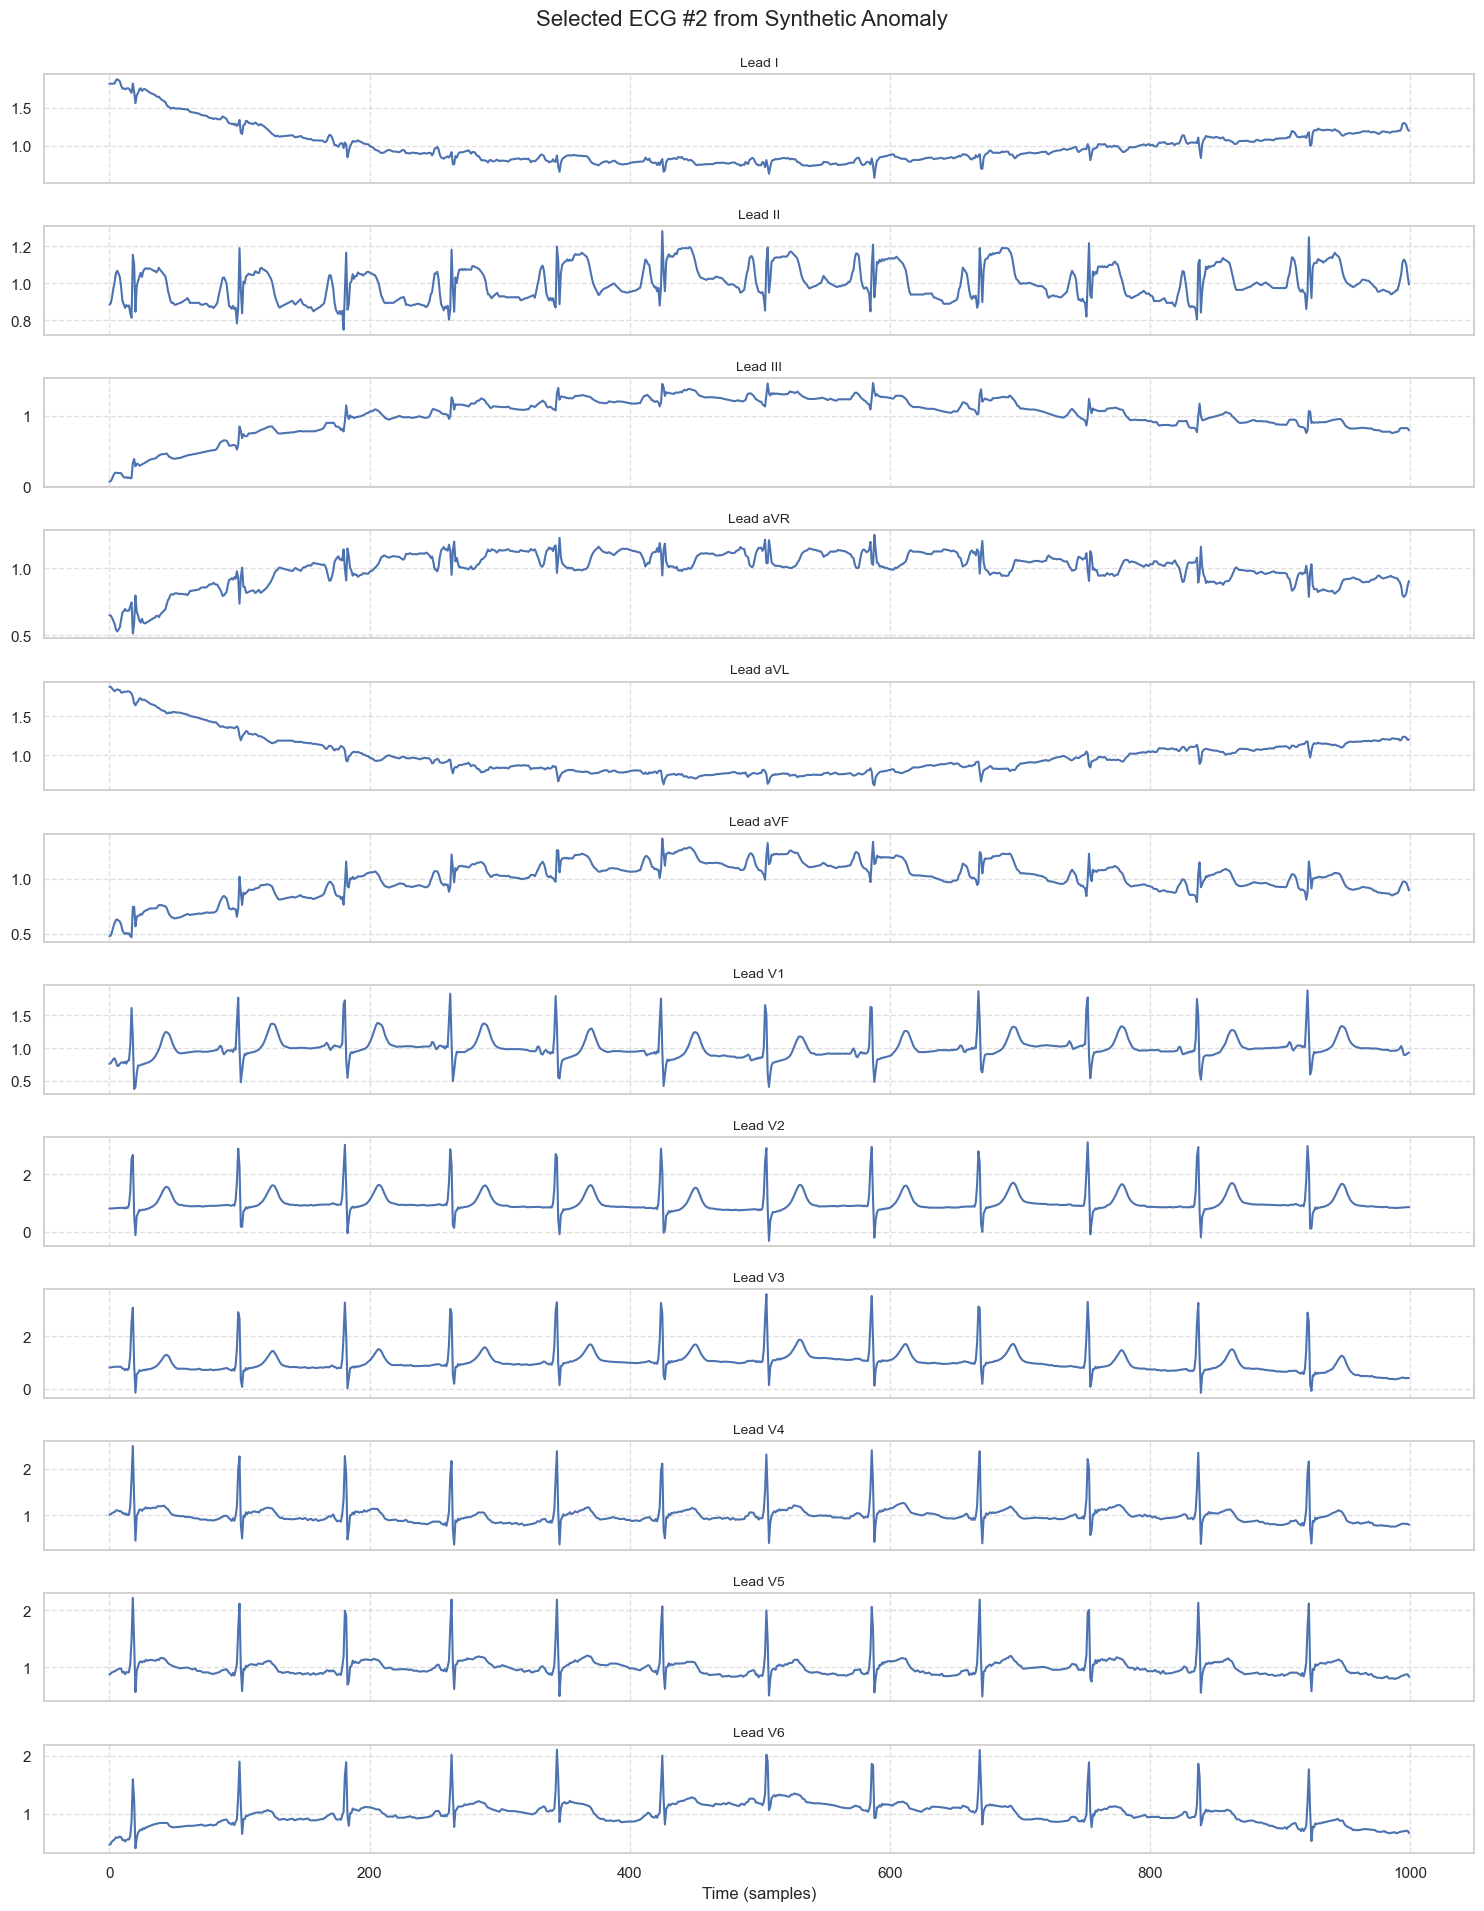

model: fastai_resnet1d_wang


C:\Users\nikolai\anaconda3\envs\NEWECGumapTest\lib\site-packages\fastai\basic_train.py:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(source, map_loca

aggregating predictions...
Anomaly score: 0.6788
Anomaly threshold: 0.0641
Anomaly status: ANOMALOUS
Classification: Normal (Confidence: 70.76%)
Class probabilities: MI: 29.24%, Normal: 70.76%
Shape of training data: (9286, 128)

Cluster 0 Size: 1782
Sub label distrobution:
  IMI    : 801
  ASMI   : 518
  ILMI   : 183
  AMI    : 66
  ALMI   : 61
  NORM   : 56
  LMI    : 29
  INJAS  : 22
  IPLMI  : 22
  IPMI   : 11
  INJAL  : 10
  INJIN  : 2
  PMI    : 1

Age: mean 63.0, std 12.4, range from 19 to 89
Sex distribution:
  Female : 1181
  Male   : 601


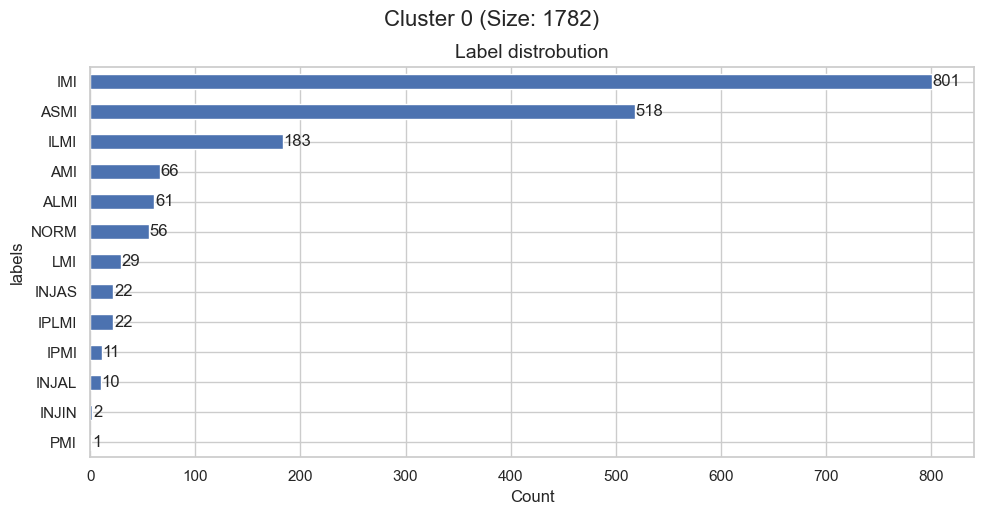


Cluster 1 Size: 5242
Sub label distrobution:
  NORM   : 5240
  IMI    : 2

Age: mean 49.6, std 17.6, range from 2 to 89
Sex distribution:
  Male   : 3116
  Female : 2126


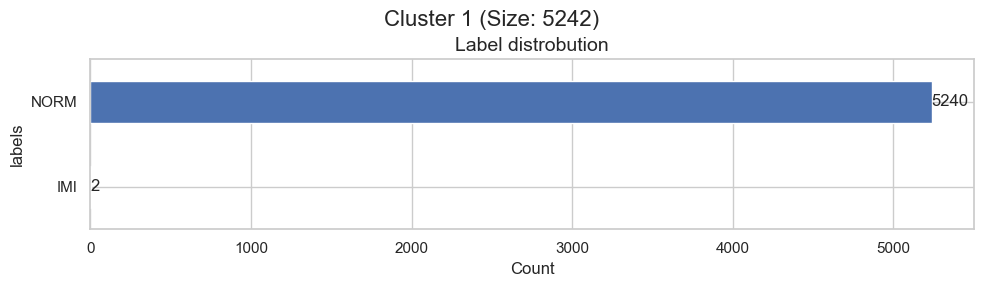


Cluster 2 Size: 2218
Sub label distrobution:
  NORM   : 1918
  IMI    : 171
  ASMI   : 42
  AMI    : 27
  LMI    : 13
  INJAS  : 13
  ALMI   : 11
  ILMI   : 8
  INJAL  : 6
  IPLMI  : 4
  PMI    : 3
  IPMI   : 2

Age: mean 59.7, std 14.6, range from 5 to 89
Sex distribution:
  Female : 1180
  Male   : 1038


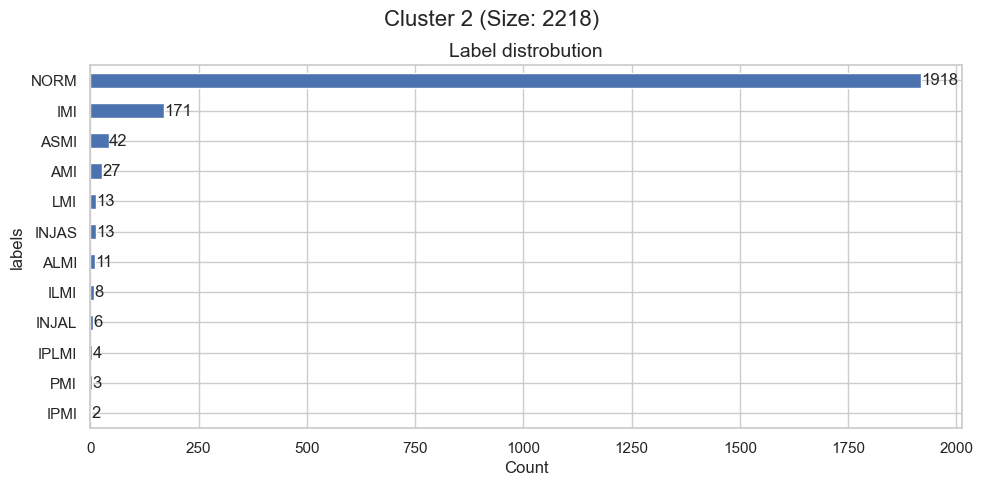


Creating 2D cluster visualization


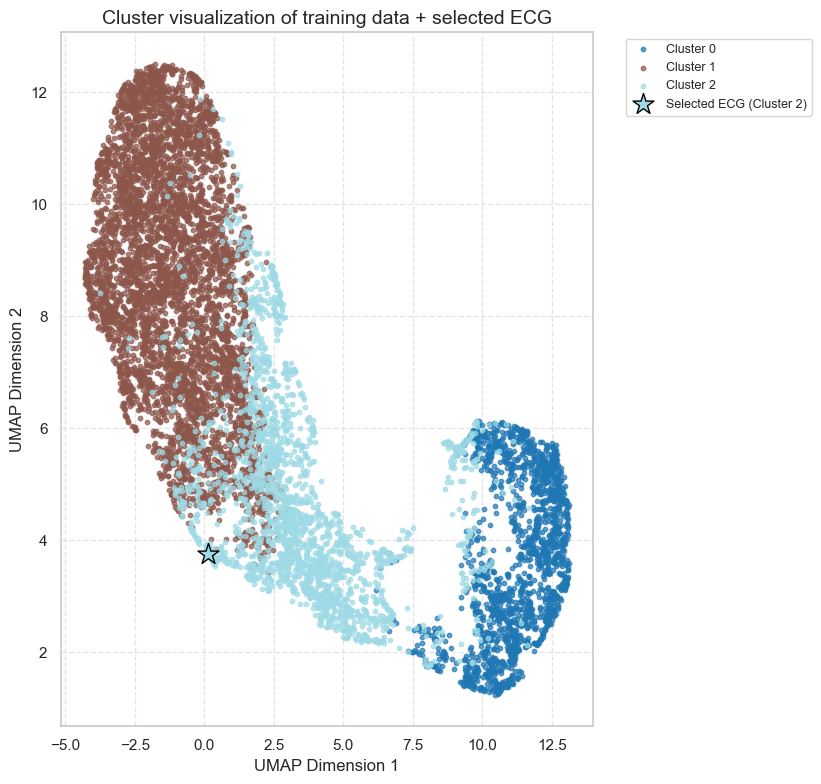

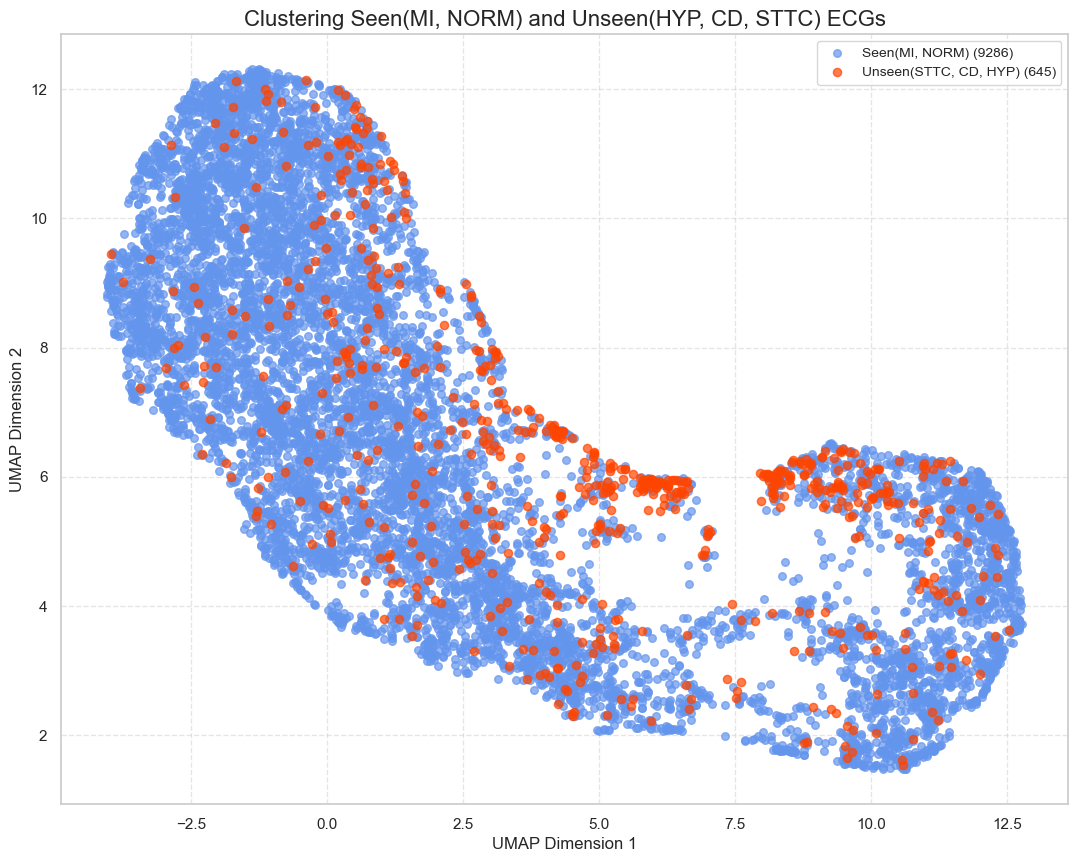


DBSCAN Outliers (Label -1): Total points = 909
  From Training NORM/MI: 722 (79.4%)
  From Test STTC/CD/HYP: 187 (20.6%)

DBSCAN Cluster 0: Total points = 7071
  From Training NORM/MI: 6788 (96.0%)
  From Test STTC/CD/HYP: 283 (4.0%)

DBSCAN Cluster 1: Total points = 1951
  From Training NORM/MI: 1776 (91.0%)
  From Test STTC/CD/HYP: 175 (9.0%)


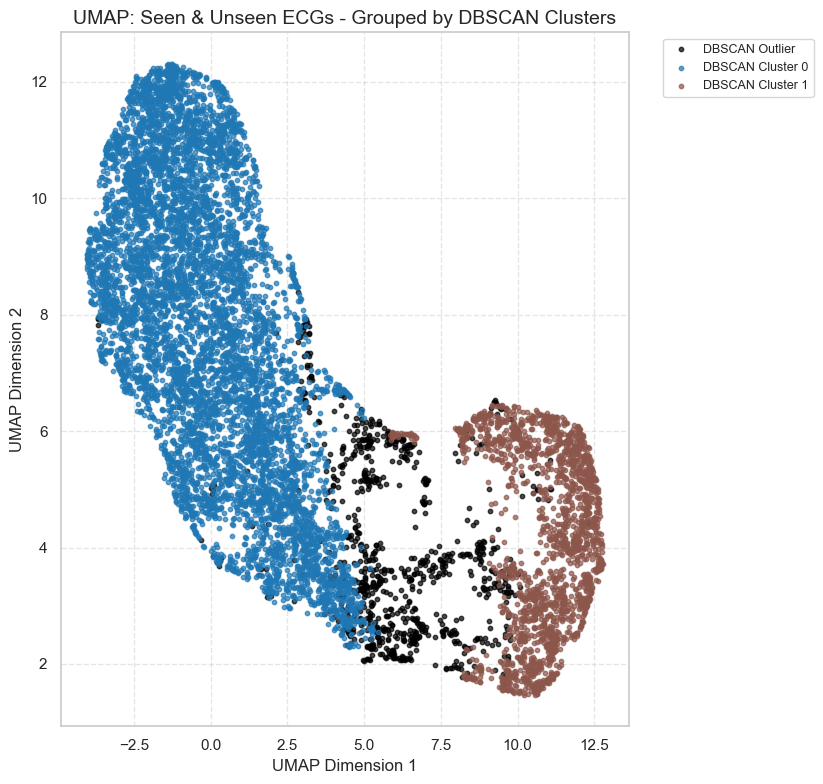

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from scipy.special import softmax
import umap
import ast
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize 
from IPython.display import HTML, display
from utils import utils
import ast
import hdbscan
# Variables from previous cells like model, standard_scalar, ensemble_scores etc are needed


dataset_choice = "synthetic"  # normal, MI, notMI, synthetic, new
ecg_index = 2  # Change index of the data sets


labels_fold_8 = labels[folds_1_8].copy()


if dataset_choice == "normal":
    selected_ecg = data_norm_ref[ecg_index]
    dataset_name = "Normal Reference (Folds 1-8)"
    score_key = 'normal_ref'
elif dataset_choice == "MI":
    selected_ecg = data_norm_test[ecg_index]
    dataset_name = "Test Norm/MI (Fold 10)"
    score_key = 'norm_test'
elif dataset_choice == "notMI":
    selected_ecg = data_notnorm_test[ecg_index]
    dataset_name = "Test Not Norm/MI (Fold 10 - Anomalies)"
    score_key = 'notnorm_test'
elif dataset_choice == "synthetic":
    selected_ecg = synthetic_anomalies[ecg_index]
    dataset_name = "Synthetic Anomaly"
    score_key = 'anomalies_synth'
elif dataset_choice == "new":
    selected_ecg = np.array(new_data[ecg_index])
    dataset_name = "New Dataset"
    score_key = 'new'


# Plot the selected ECG
plt.figure(figsize=(15, 20))
lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Goes through each lead
for i in range(12):
    ax = plt.subplot(12, 1, i + 1)
    plt.plot(selected_ecg[:, i]) 
    ax.set_title(f'Lead {lead_names[i]}', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    if i < 11:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Time (samples)")

        
# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(hspace=0.4)
plt.suptitle(f"Selected ECG #{ecg_index} from {dataset_name}", fontsize=16, y=0.985)
plt.show()


# Use anomaly score to set anomaly status
anomaly_score = ensemble_scores[score_key][ecg_index]
anomaly_status = "ANOMALOUS" if anomaly_score > ensemble_threshold else "NORMAL"


# Code to classfy the ECG using the ResNet model and softmax
ecg_sample_batch = np.expand_dims(selected_ecg, axis=0)
ecg_sample_standardized = utils.apply_standardizer(ecg_sample_batch, standard_scaler)
y_pred = model.predict(ecg_sample_standardized)
probabilities = softmax(y_pred, axis=1)[0]
predicted_class_index = np.argmax(probabilities)
class_names = ['MI', 'Normal']
predicted_class_name = class_names[predicted_class_index]
# print classification score
print(f"Anomaly score: {anomaly_score:.4f}")
print(f"Anomaly threshold: {ensemble_threshold:.4f}")
print(f"Anomaly status: {anomaly_status}")
print(f"Classification: {predicted_class_name} (Confidence: {probabilities[predicted_class_index]:.2%})")
print(f"Class probabilities: MI: {probabilities[0]:.2%}, Normal: {probabilities[1]:.2%}")










# Clustering code


# Extract features from ECG
layer_features = {}
def hook_fn_dbscan(module_name):
    def hook(module, inp, out):
        layer_features[module_name] = out.detach().cpu().numpy()
    return hook

target_layer_for_hook = pytorch_model[-1][-2]
hook = target_layer_for_hook.register_forward_hook(hook_fn_dbscan("Batch_norm"))

with torch.no_grad():
    tensor = torch.tensor(ecg_sample_standardized, dtype=torch.float32).to(device)
    tensor = tensor.permute(0, 2, 1)
    _ = pytorch_model(tensor)

current_features = layer_features["Batch_norm"].squeeze()
hook.remove()

# Normalize ECG
current_features_reshaped = current_features.reshape(1, -1)
current_features_norm = normalize(current_features_reshaped, norm='l2')


# Features for clustering from cell 1
train_features_raw = feats_norm_ref_norm
features_notnorm_test_set = feats_notnorm_test_norm

print(f"Shape of training data: {train_features_raw.shape}")


# Combine Selected ECG and training features
all_data = np.concatenate([train_features_raw, current_features_norm], axis=0)








clustering_algorithm = 'GMM' # DBSCAN, KMeans, GMM, HDBSCAN









if clustering_algorithm == 'DBSCAN':
    # DBSCAN parameters
    db = DBSCAN(eps=0.32, min_samples=10, metric="euclidean", n_jobs=-1)
    cluster_labels = db.fit_predict(all_data)
    # The last label corresponds to the selected ECG.
    ecg_cluster_label = cluster_labels[-1]
    print(f"\nSelected ECG cluster label: {ecg_cluster_label}")
    # Assign cluster labels to training data
    train_cluster_labels = cluster_labels[:-1]


elif clustering_algorithm == 'KMeans':
    n_clusters_kmeans = 5 
    kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=50, n_init=10)
    cluster_labels = kmeans.fit_predict(all_data)
    ecg_cluster_label = cluster_labels[-1]
    train_cluster_labels = cluster_labels[:-1]



elif clustering_algorithm == 'GMM': 
    gmm = GaussianMixture(n_components=3, random_state=50)
    cluster_labels = gmm.fit_predict(all_data)
    ecg_cluster_label = cluster_labels[-1]
    train_cluster_labels = cluster_labels[:-1]

elif clustering_algorithm == 'HDBSCAN':      
    hdb = hdbscan.HDBSCAN(min_cluster_size=20, metric='euclidean', gen_min_span_tree=True)
    cluster_labels = hdb.fit_predict(all_data)
    ecg_cluster_label = cluster_labels[-1]
    train_cluster_labels = cluster_labels[:-1]












labels_fold_8 = labels_fold_8.copy()
labels_fold_8["clusters"] = train_cluster_labels






















# MI codes
mi_codes = {"MI", "IMI", "ASMI", "AMI", "ALMI", "ILMI", "LMI", "INJAS", "INJAL", "IPLMI",
            "IPMI", "INJIN", "INJLA", "PMI"}

label_col = 'superdiagnosticNORMandMI'

# Extracts MI or NORM from incoming list
def label_mapper(x): 
    if isinstance(x, list) and len(x) > 0:
        item_str = x[0]
        if item_str in mi_codes: return "MI"
        elif item_str == "NORM": return "NORM"
    return None

# Maps primary diagnosis using label mapper
labels_fold_8["primary_diag"] = labels_fold_8[label_col].apply(label_mapper)

labels_fold_8_filtered = labels_fold_8[labels_fold_8["primary_diag"].isin(["MI", "NORM"])].copy()





def safe_literal_eval(s): 
    if isinstance(s, dict): return s
    if isinstance(s, str):
        if s.startswith('{') and s.endswith('}'):
            try: return ast.literal_eval(s)
            except: return {}
        else: return {}
    return {}

# Defines new column where mi sublabels and the normal label is added for more detailed diagnosis
labels_fold_8_filtered["sub_labels"] = labels_fold_8_filtered["scp_codes"].apply(
    lambda s: next(
        (k for k, v in safe_literal_eval(s).items() if k in mi_codes and v > 0),
        "NORM"
    )
)

# Creates new dataframe
analysis_df = labels_fold_8_filtered[labels_fold_8_filtered["age"].between(0, 100, inclusive="both")].copy()






# Uses the clusters column from the clustering algorithme to group ECGs by their cluster label
for cid, grp in analysis_df.groupby("clusters"):
    print(f"\nCluster {cid} Size: {len(grp)}")

    # Sub label distrobution
    print("Sub label distrobution:")
    sub_label_counts = grp["sub_labels"].value_counts().sort_values(ascending=False)
    for lbl_val, count in sub_label_counts.items():
        print(f"  {str(lbl_val):<7}: {count}")

    # Age distrobution and analytics
    age_data = grp["age"].dropna()
    avg_age = age_data.mean()
    std_age = age_data.std()
    min_age = age_data.min()
    max_age = age_data.max()
    print(f"\nAge: mean {avg_age:.1f}, std {std_age:.1f}, range from {min_age:.0f} to {max_age:.0f}")


    # Sex distribution
    sex_map = {1.0: "Male", 0.0: "Female"}
    sex_series = grp["sex"].map(sex_map).fillna("Unknown").value_counts()
    print("Sex distribution:")
    for sex_lbl, sex_count in sex_series.items():
        print(f"  {sex_lbl:<7}: {sex_count}")


        
    # count number of labels in the cluster
    sub_label_counts_plot = grp["sub_labels"].value_counts().sort_values(ascending=True)
    num_labels = len(sub_label_counts_plot)
    fig_height = max(3, 1.5 + num_labels * 0.3)

    # Set up plot
    fig, ax = plt.subplots(figsize=(10, fig_height)) 
    fig.suptitle(f"Cluster {cid} (Size: {len(grp)})", fontsize=16, y=0.98)
    sub_label_counts_plot.plot(kind='barh', ax=ax)
    ax.set_title("Label distrobution", fontsize=14)
    ax.set_xlabel("Count", fontsize=12)
    ax.set_ylabel("labels", fontsize=12)

    # Add values for each bar
    for i, v in enumerate(sub_label_counts_plot):
        ax.text(v + 0.5, i, str(v), va='center', fontweight='medium') 
    
    # Show plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    
    



    
# 2D Cluster Visualisation
print("\nCreating 2D cluster visualization")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=50, metric='euclidean')
all_data_umap = reducer.fit_transform(all_data)



train_umap_2d = all_data_umap[:-1]
ecg_umap_2d = all_data_umap[-1:]

plt.figure(figsize=(10, 8))
unique_train_cluster_labels = np.unique(train_cluster_labels)
cmap = plt.cm.get_cmap("tab20", len(unique_train_cluster_labels))
cluster_colors = {label: cmap(i) for i, label in enumerate(unique_train_cluster_labels) if label != -1}
cluster_colors[-1] = 'black'

for lbl in unique_train_cluster_labels:
    color = cluster_colors[lbl]
    lbl_name = f"Cluster {lbl}" if lbl != -1 else "Outlier"
    pts_indices = np.where(train_cluster_labels == lbl)[0]
    if len(pts_indices) > 0:
        plt.scatter(train_umap_2d[pts_indices, 0], train_umap_2d[pts_indices, 1], s=10, color=color, label=lbl_name, alpha=0.7)

star_color = cluster_colors.get(ecg_cluster_label, "magenta")
plt.scatter(ecg_umap_2d[0, 0], ecg_umap_2d[0, 1], s=250, marker="*", color=star_color,
            edgecolors="black", linewidths=1.0, label=f"Selected ECG (Cluster {ecg_cluster_label})")

plt.title("Cluster visualization of training data + selected ECG", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# Dashboard
score_marker_position = min(max(anomaly_score * 100, 0), 100)
prob_mi_pct = f"{probabilities[0]:.1%}"
prob_norm_pct = f"{probabilities[1]:.1%}"
prob_mi_width = probabilities[0] * 100
prob_norm_width = probabilities[1] * 100


# A f-string containing HTML and CSS elements with variables from code above
# to display the information in a simple dashboard
# The first part define the CSS class styles and content, while the second part structures HTML into a dashboard.
dashboard_html = f"""



<style>
    .ecg-dashboard {{ font-family: Arial, sans-serif; max-width: 800px; margin: 20px auto; padding: 0; border: 1px solid #ddd; border-radius: 8px; box-shadow: 2px 2px 5px rgba(0,0,0,0.1); overflow: hidden; }}
    .ecg-title {{ text-align: center; margin: 0; padding: 15px; font-size: 18px; font-weight: bold; color: #fff; background-color: #4a90e2; }}
    .ecg-subtitle {{ text-align: center; margin-bottom: 25px; padding: 5px 0; font-style: italic; color: #666; background-color: #f4f4f4; border-bottom: 1px solid #ddd; }}
    .dashboard-content {{ display: flex; gap: 30px; justify-content: center; padding: 20px; }}
    .dashboard-section {{ width: 45%; text-align: center; }}
    .section-title {{ font-weight: bold; margin-bottom: 10px; font-size: 16px; color: #333; }}
    .anomaly-status {{ display: inline-block; padding: 8px 15px; margin: 10px 0; font-weight: bold; border-radius: 20px; color: white; text-align: center; width: 90%; box-sizing: border-box; }}
    .status-anomalous {{ background-color: #f44336; }}
    .status-normal {{ background-color: #4caf50; }}
    .status-mi {{ background-color: #ff9800; }}
    .status-normal-ecg {{ background-color: #2196f3; }}
    .gauge-container {{ margin: 35px 0 25px 0; position: relative; height: 100px; }}
    .gauge-bar {{ width: 100%; height: 12px; background: linear-gradient(to right, #4caf50, #ffeb3b, #f44336); border-radius: 6px; position: relative; }}
    .gauge-labels {{ display: flex; justify-content: space-between; margin-top: 5px; font-size: 12px; color: #666; }}
    .threshold-line {{ position: absolute; top: -15px; bottom: -15px; width: 2px; background-color: #333; left: {ensemble_threshold * 100}%; z-index: 1; }}
    .threshold-label {{ position: absolute; top: -32px; left: {ensemble_threshold * 100}%; transform: translateX(-50%); background-color: #333; color: white; padding: 3px 8px; border-radius: 10px; font-size: 12px; white-space: nowrap; z-index: 3; }}
    .score-marker {{ position: absolute; top: -9px; left: {score_marker_position}%; width: 30px; height: 30px; background-color: white; border: 2px solid #333; border-radius: 50%; transform: translateX(-50%); display: flex; align-items: center; justify-content: center; font-weight: bold; font-size: 12px; z-index: 2; box-shadow: 0px 0px 4px rgba(0,0,0,0.3); }}
    .probability-container {{ margin: 15px 0; padding: 0 10px; }}
    .probability-bar {{ height: 25px; margin: 8px 0; border-radius: 4px; position: relative; overflow: hidden; background-color: #e0e0e0; }}
    .probability-fill {{ height: 100%; border-radius: 4px; position: absolute; left: 0; top: 0; }}
    .probability-label {{ position: absolute; left: 10px; top: 50%; transform: translateY(-50%); color: white; font-weight: bold; text-shadow: 1px 1px 1px rgba(0,0,0,0.5); z-index: 1; }}
    .probability-value {{ position: absolute; right: 10px; top: 50%; transform: translateY(-50%); color: white; font-weight: bold; text-shadow: 1px 1px 1px rgba(0,0,0,0.5); z-index: 1; }}
    .mi-bar .probability-fill {{ background-color: #ff9800; width: {prob_mi_width}%; }}
    .normal-bar .probability-fill {{ background-color: #2196f3; width: {prob_norm_width}%; }}
</style>




<div class="ecg-dashboard">
    <div class="ecg-title">ECG Analysis Results</div>
    <div class="dashboard-content">
        <div class="dashboard-section">
            <div class="section-title">Anomaly Detection</div>
            <div class="anomaly-status {'status-anomalous' if anomaly_status == 'ANOMALOUS' else 'status-normal'}">{anomaly_status}</div>
            <div class="gauge-container">
                <div class="gauge-bar"></div>
                <div class="threshold-line"></div>
                <div class="threshold-label">Threshold: {ensemble_threshold:.3f}</div>
                <div class="score-marker">{anomaly_score:.2f}</div>
                <div class="gauge-labels"><span>Low Score (Normal)</span><span>High Score (Anomalous)</span></div>
            </div>
        </div>
        <div class="dashboard-section">
            <div class="section-title">MI vs Normal Classification</div>
            <div class="anomaly-status {'status-mi' if predicted_class_name == 'MI' else 'status-normal-ecg'}">{predicted_class_name}</div>
            <div class="probability-container">
                <div class="probability-bar mi-bar">
                    <div class="probability-fill"></div>
                    <span class="probability-label">MI</span>
                    <span class="probability-value">{prob_mi_pct}</span>
                </div>
                <div class="probability-bar normal-bar">
                    <div class="probability-fill"></div>
                    <span class="probability-label">Normal</span>
                    <span class="probability-value">{prob_norm_pct}</span>
                </div>
            </div>
        </div>
    </div>
</div>
"""
display(HTML(dashboard_html))























# combining features
comparison_features = np.concatenate([train_features_raw, features_notnorm_test_set], axis=0)
num_train_comparison = len(train_features_raw)
num_test_comparison = len(features_notnorm_test_set)

# Using DBSCAN
dbscan_comparison = DBSCAN(eps=0.32, min_samples=10, metric="euclidean", n_jobs=-1)
comparison_cluster_labels = dbscan_comparison.fit_predict(comparison_features)


# Umap reduction
reducer_comparison = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, metric='euclidean')
comparison_reduced_2d = reducer_comparison.fit_transform(comparison_features)


train_reduced_comparison = comparison_reduced_2d[:num_train_comparison]
test_reduced_comparison = comparison_reduced_2d[num_train_comparison:]

# Compare with diffrent colors
plt.figure(figsize=(13, 10), dpi=100)
plt.scatter(train_reduced_comparison[:, 0], train_reduced_comparison[:, 1],
            color='cornflowerblue', label=f'Seen(MI, NORM) ({num_train_comparison})', alpha=0.7, s=30)
plt.scatter(test_reduced_comparison[:, 0], test_reduced_comparison[:, 1],
            color='orangered', label=f'Unseen(STTC, CD, HYP) ({num_test_comparison})', alpha=0.7, s=35)

# Show cluster
plt.title("Clustering Seen(MI, NORM) and Unseen(HYP, CD, STTC) ECGs", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


unique_comparison_labels = np.unique(comparison_cluster_labels)

for label in unique_comparison_labels:
    current_cluster_mask = (comparison_cluster_labels == label)
    num_in_current_cluster = np.sum(current_cluster_mask)

    # ECGs from seen Norm mi set
    train_points_in_cluster = np.sum(current_cluster_mask[:num_train_comparison])

    # ECGs from unseen STTC CD HYP set
    test_points_in_cluster = np.sum(current_cluster_mask[num_train_comparison:])

    cluster_desc = f"DBSCAN Cluster {label}" if label != -1 else "DBSCAN Outliers (Label -1)"
    print(f"\n{cluster_desc}: Total points = {num_in_current_cluster}")
    if num_in_current_cluster > 0: 
        print(f"  From Training NORM/MI: {train_points_in_cluster} ({train_points_in_cluster/num_in_current_cluster*100:.1f}%)")
        print(f"  From Test STTC/CD/HYP: {test_points_in_cluster} ({test_points_in_cluster/num_in_current_cluster*100:.1f}%)")


        
        
        
        
        
        
        

# set up figure, with labels
plt.figure(figsize=(10, 8), dpi=100) 
unique_dbscan_labels = np.unique(comparison_cluster_labels)
num_clusters_found = len(unique_dbscan_labels)


cluster_cmap = plt.cm.get_cmap("tab20", num_clusters_found)

cluster_colors_map = {}
sorted_labels_for_plotting = sorted(list(unique_dbscan_labels))
color_index = 0
for label_val_map in sorted_labels_for_plotting:
    if label_val_map == -1:
        cluster_colors_map[label_val_map] = 'black'
    else:
        cluster_colors_map[label_val_map] = cluster_cmap(color_index % (cluster_cmap.N if cluster_cmap.N > 0 else 1))
        color_index += 1

# plot the legend, go through each cluster
for label_val_plot in sorted_labels_for_plotting: 
    color_to_use = cluster_colors_map[label_val_plot]
    legend_label = f"DBSCAN Cluster {label_val_plot}" if label_val_plot != -1 else "DBSCAN Outlier"
    current_cluster_points_mask = (comparison_cluster_labels == label_val_plot)
    points_in_current_cluster = comparison_reduced_2d[current_cluster_points_mask]

    if len(points_in_current_cluster) > 0:
        plt.scatter(points_in_current_cluster[:, 0], points_in_current_cluster[:, 1],
                    s=10, 
                    color=color_to_use,
                    alpha=0.7, 
                    marker='o',
                    label=legend_label)

# Add title and other text
plt.title("UMAP: Seen & Unseen ECGs - Grouped by DBSCAN Clusters", fontsize=14) 
plt.xlabel("UMAP Dimension 1") 
plt.ylabel("UMAP Dimension 2")

# generate legend
handles, labels = plt.gca().get_legend_handles_labels()
if handles: 
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)

plt.grid(True, linestyle='--', alpha=0.5) 
plt.tight_layout(rect=[0, 0, 0.85, 1])  
plt.show()